In [ ]:
!pip install japanize-matplotlib | tail -n 1
!pip install torchviz | tail -1
!pip install torchinfo | tail -n 1

import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib

plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams['axes.grid'] = True

import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torchviz import make_dot
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
from tqdm.notebook import tqdm
from torchinfo import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

def eval_loss(loader, device, net, criterion):
    images, labels = next(iter(loader))
    inputs = images.to(device)
    labels = labels.to(device)
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    return loss

def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):
    base_epochs = len(history)
    for epoch in range(base_epochs, num_epochs+base_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        net.train()
        count = 0
        for inputs, labels in tqdm(train_loader):
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            predicted = torch.max(outputs, 1)[1]
            train_acc += (predicted == labels).sum().item()
            avg_train_loss = train_loss / count
            avg_train_acc = train_acc / count

        net.eval()
        count = 0
        for inputs, labels in test_loader:
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            predicted = torch.max(outputs, 1)[1]
            val_acc += (predicted == labels).sum().item()
            avg_val_loss = val_loss / count
            avg_val_acc = val_acc / count

        print(f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
        item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
        history = np.vstack((history, item))
    return history

def evaluate_history(history):
    print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}')
    print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )
    num_epochs = len(history)
    if num_epochs < 10:
        unit = 1
    else:
        unit = num_epochs / 10
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='訓練')
    plt.plot(history[:,0], history[:,3], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('損失')
    plt.title('学習曲線(損失)')
    plt.legend()
    plt.show()
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,2], 'b', label='訓練')
    plt.plot(history[:,0], history[:,4], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('精度')
    plt.title('学習曲線(精度)')
    plt.legend()
    plt.show()

def show_images_labels(loader, classes, net, device):
    images, labels = next(iter(loader))
    n_size = min(len(images), 50)
    if net is not None:
        inputs = images.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        predicted = torch.max(outputs,1)[1]
    plt.figure(figsize=(20, 15))
    for i in range(n_size):
        ax = plt.subplot(5, 10, i + 1)
        label_name = classes[labels[i]]
        if net is not None:
            predicted_name = classes[predicted[i]]
            if label_name == predicted_name:
                c = 'k'
            else:
                c = 'b'
            ax.set_title(label_name + ':' + predicted_name, c=c, fontsize=20)
        else:
            ax.set_title(label_name, fontsize=20)
        image_np = images[i].numpy().copy()
        img = np.transpose(image_np, (1, 2, 0))
        plt.imshow(img)
        ax.set_axis_off()
    plt.show()

def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True


cuda:0


In [ ]:
from torchvision import models

net = models.resnet18(pretrained = True)
p = nn.AdaptiveAvgPool2d((1,1))
print(p)

l1 = nn.Linear(32, 10)
print(l1)

inputs = torch.randn(100, 32, 16, 16)
m1 = p(inputs)
m2 = m1.view(m1.shape[0],-1)
m3 = l1(m2)
print(m1.shape)
print(m2.shape)
print(m3.shape)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
n_output = len(classes)

transform_train = transforms.Compose([
  transforms.Resize(112),
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.ToTensor(),
  transforms.Normalize(0.5, 0.5),
  transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

transform = transforms.Compose([
  transforms.Resize(112),
  transforms.ToTensor(),
  transforms.Normalize(0.5, 0.5)
])

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 192MB/s]


AdaptiveAvgPool2d(output_size=(1, 1))
Linear(in_features=32, out_features=10, bias=True)
torch.Size([100, 32, 1, 1])
torch.Size([100, 32])
torch.Size([100, 10])


In [ ]:
from torchvision import models

data_root = './data'

train_set = datasets.CIFAR10(
    root = data_root, train = True,
    download = True, transform = transform_train)

test_set = datasets.CIFAR10(
    root = data_root, train = False,
    download = True, transform = transform)

batch_size = 50

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set,  batch_size=batch_size, shuffle=False)

net = models.resnet18(pretrained = True)
print(net)
net = net.to(device)
summary(net,(100,3,112,112))
print(net.fc)
print(net.fc.in_features)

100%|██████████| 170M/170M [00:04<00:00, 34.6MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

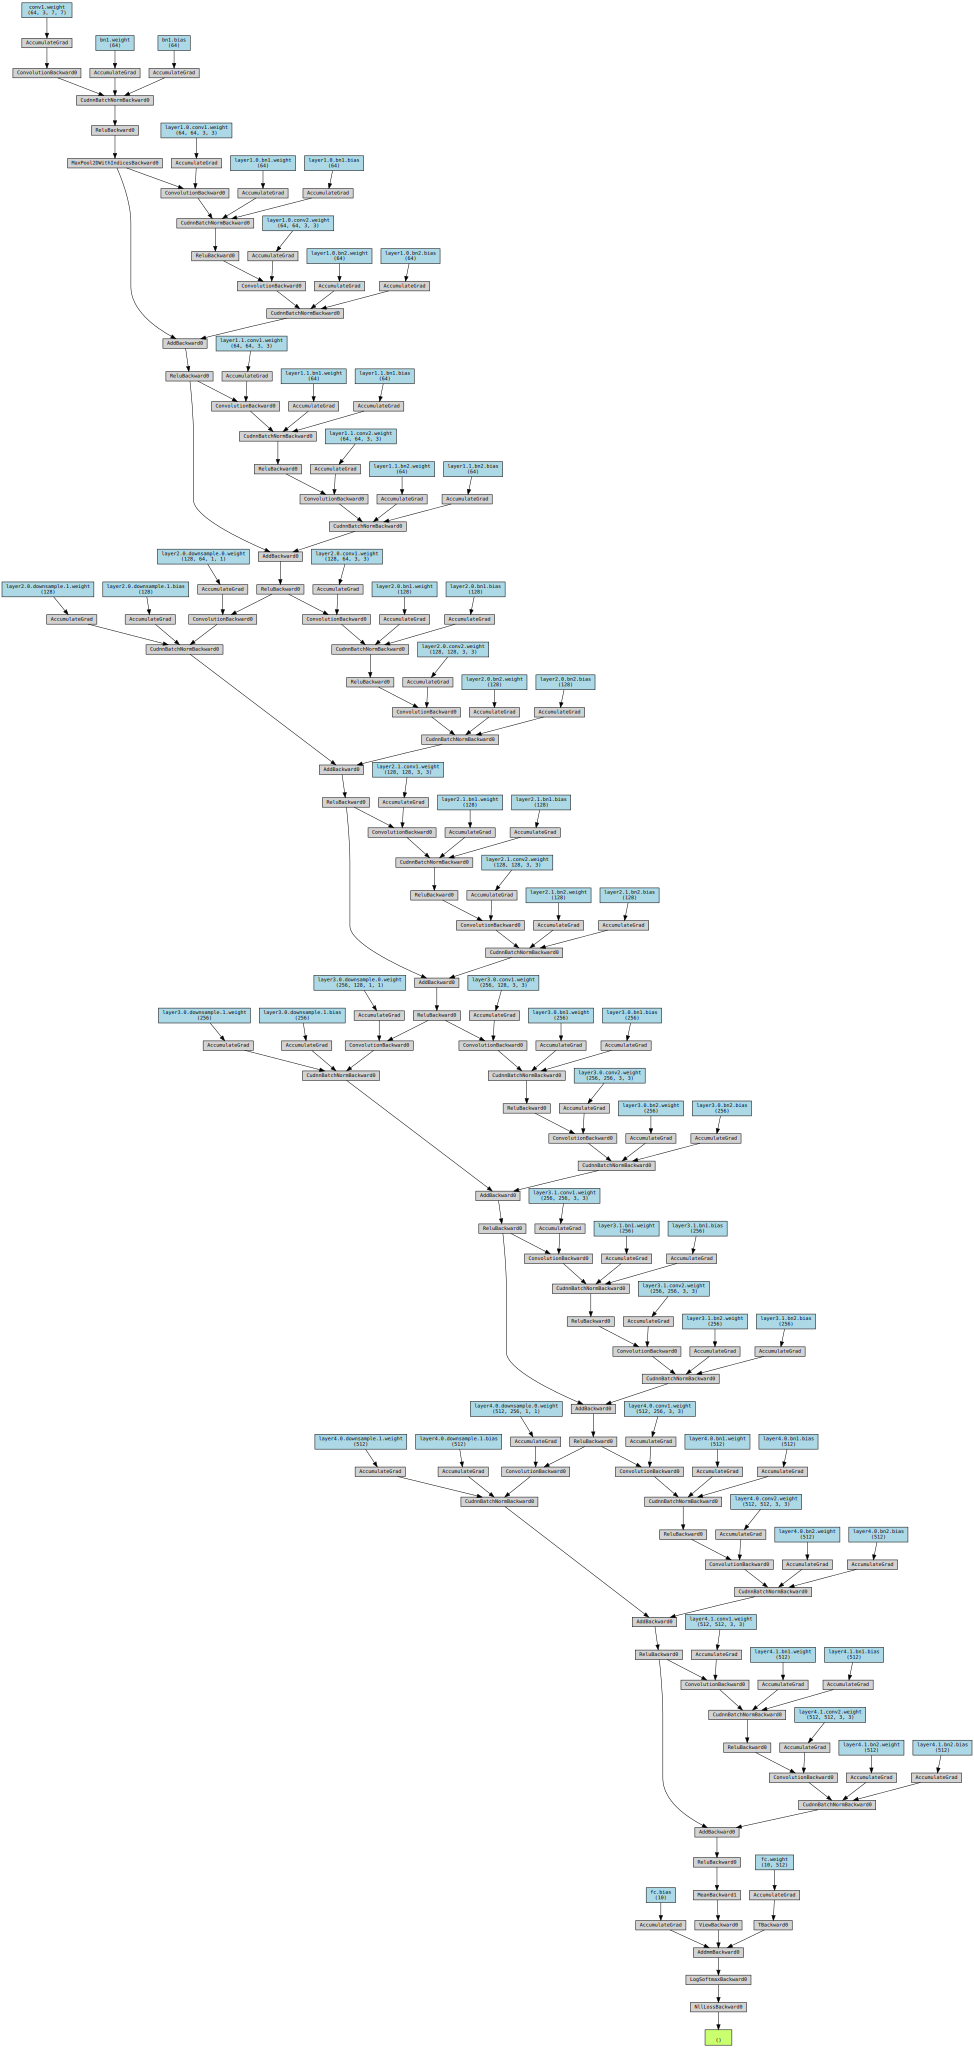

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
torch_seed()

fc_in_features = net.fc.in_features
net.fc = nn.Linear(fc_in_features, n_output)
print(net)

net = net.to(device)
summary(net,(100,3,224,224))

criterion = nn.CrossEntropyLoss()
loss = eval_loss(test_loader, device, net, criterion)
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)
print(net)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1/5], loss: 0.01201 acc: 0.79550 val_loss: 0.00527, val_acc: 0.90870


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [2/5], loss: 0.00642 acc: 0.88846 val_loss: 0.00413, val_acc: 0.92770


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [3/5], loss: 0.00513 acc: 0.91098 val_loss: 0.00396, val_acc: 0.93370


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [4/5], loss: 0.00435 acc: 0.92488 val_loss: 0.00357, val_acc: 0.93970


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [5/5], loss: 0.00384 acc: 0.93242 val_loss: 0.00359, val_acc: 0.93920
初期状態: 損失: 0.00527 精度: 0.90870
最終状態: 損失: 0.00359 精度: 0.93920


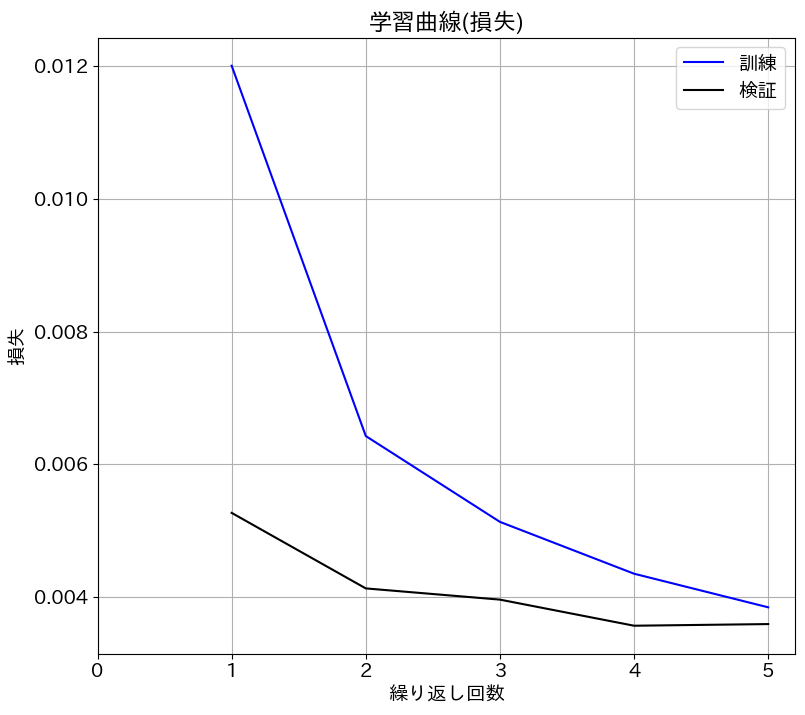

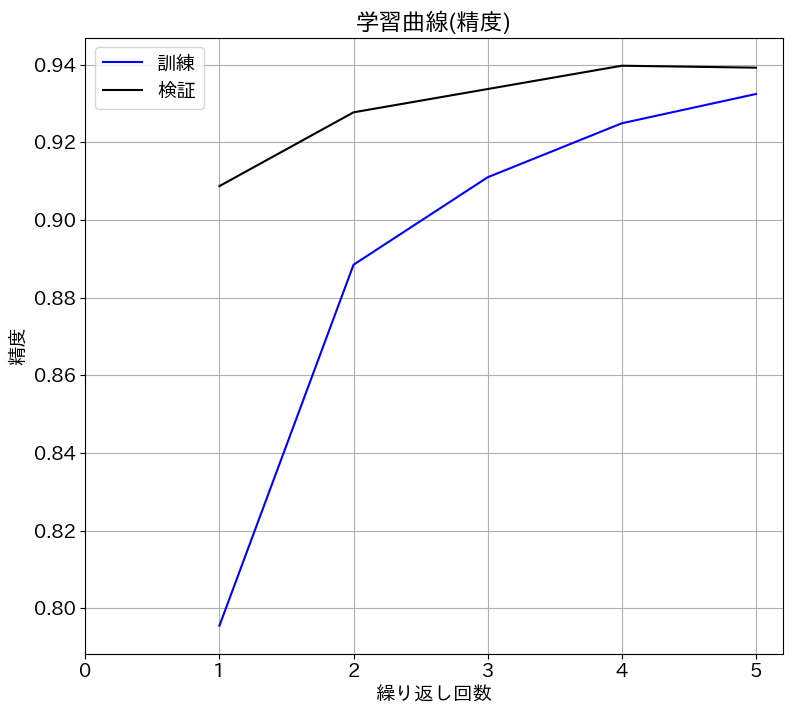

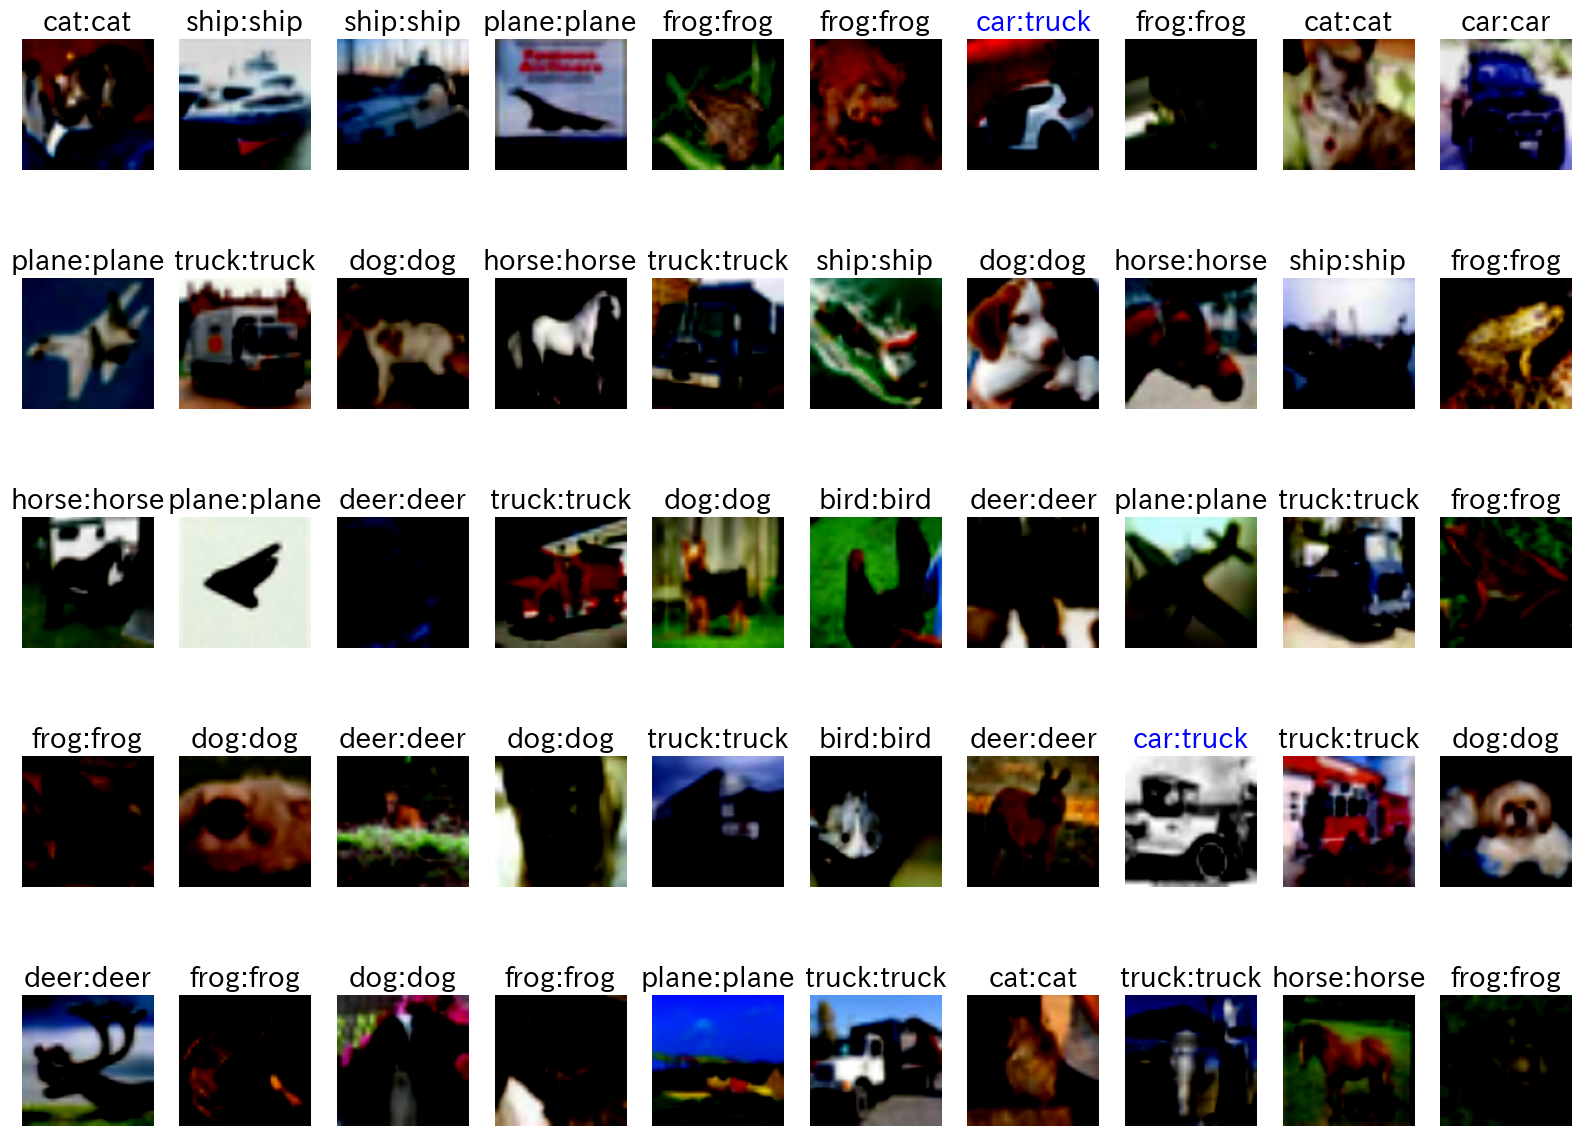

In [ ]:
net = net.to(device)
summary(net,(100,3,112,112))

torch_seed()

net = models.resnet18(pretrained = True)
fc_in_features = net.fc.in_features
net.fc = nn.Linear(fc_in_features, n_output)
net = net.to(device)
lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
history = np.zeros((0, 5))
num_epochs = 5

history = fit(net, optimizer, criterion, num_epochs,
        train_loader, test_loader, device, history)

evaluate_history(history)
show_images_labels(test_loader, classes, net, device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

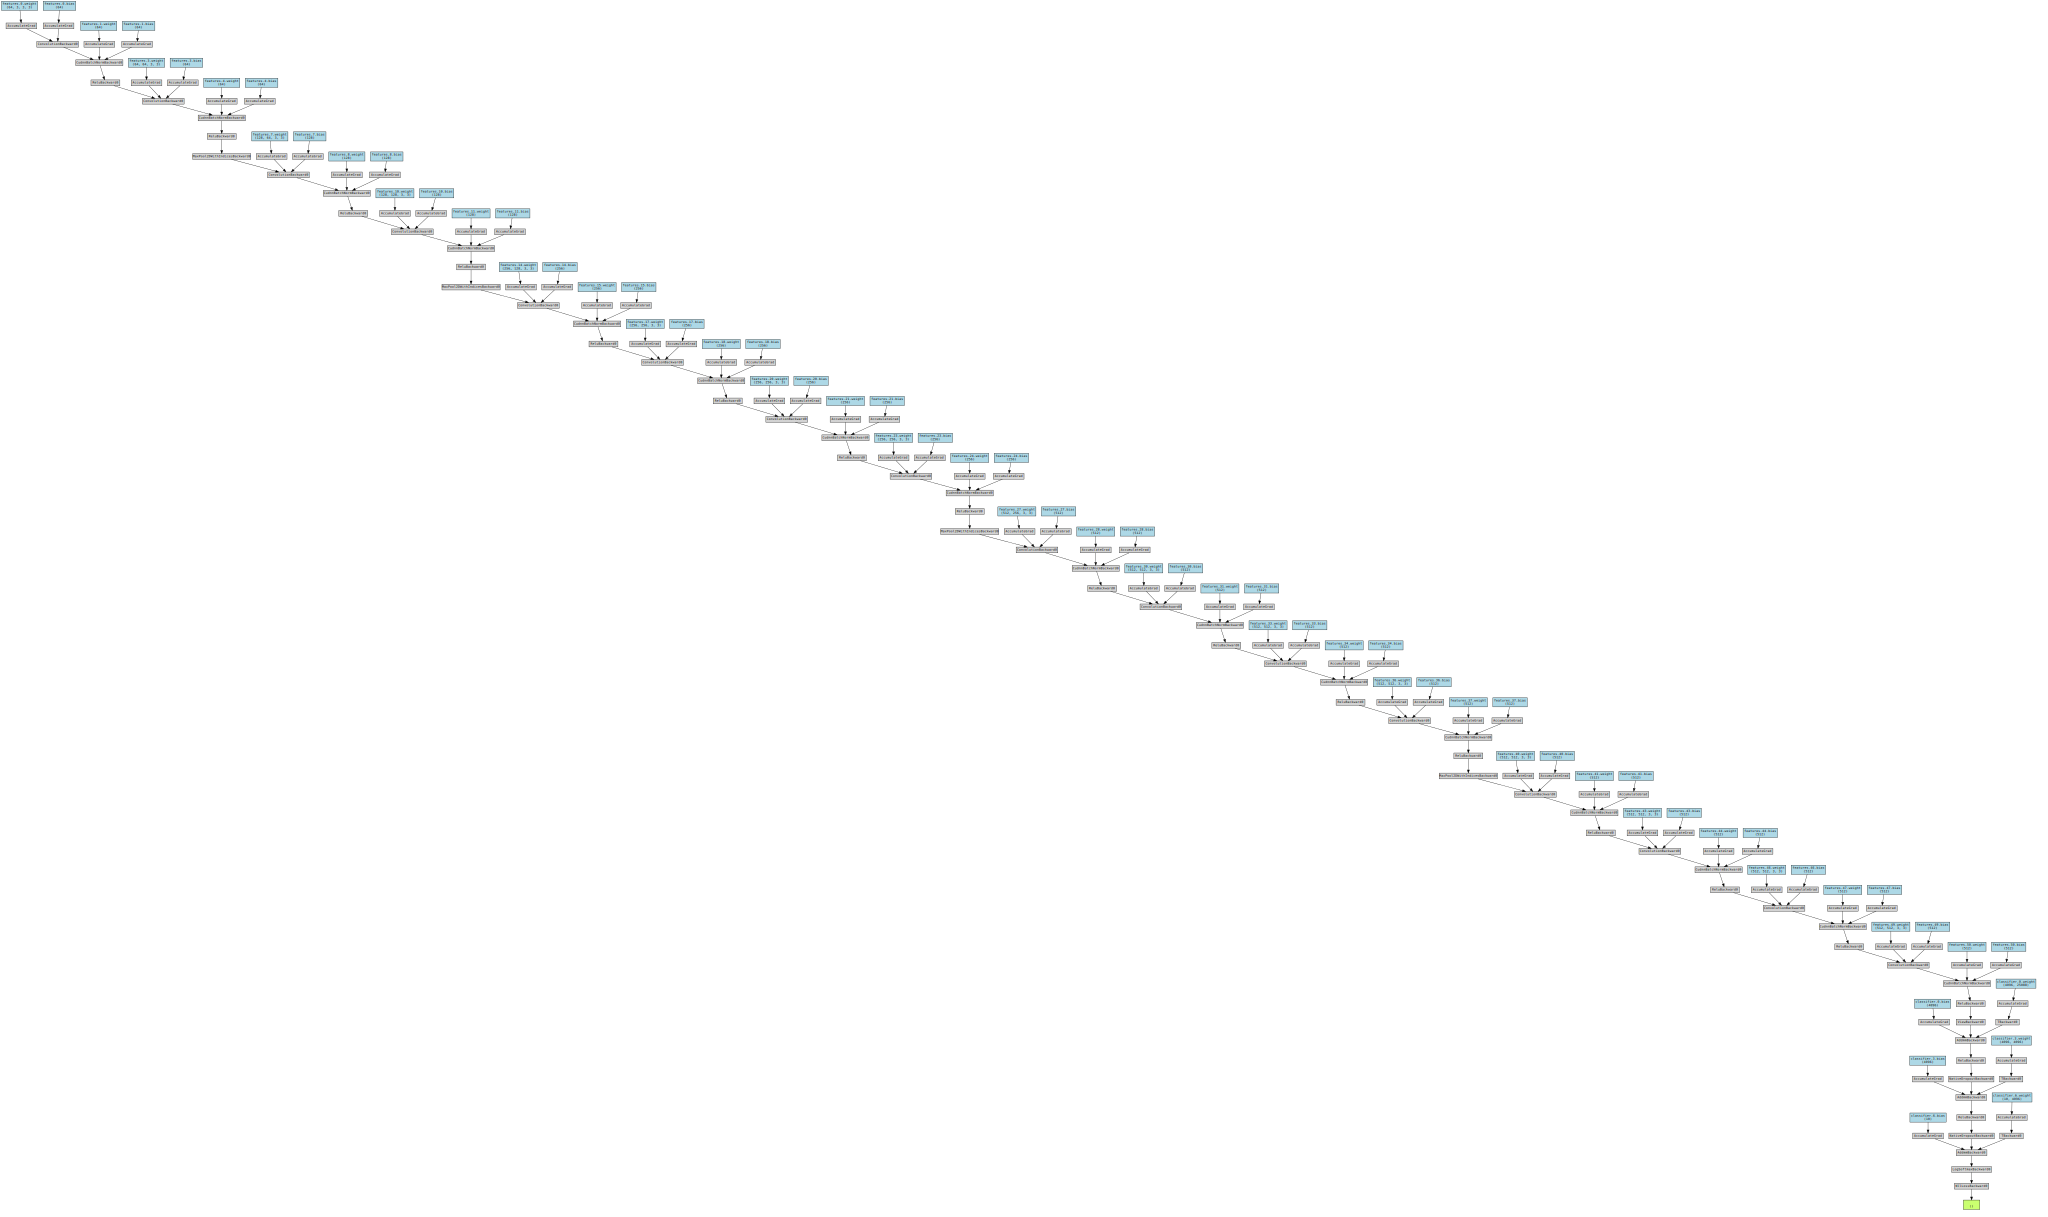

In [ ]:
from torchvision import models

net = models.vgg19_bn(pretrained = True)
print(net)
print(net.classifier[6])

torch_seed()

in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, n_output)
net.features = net.features[:-1]
net.avgpool = nn.Identity()
net = net.to(device)
summary(net,(100,3,112,112))

criterion = nn.CrossEntropyLoss()
loss = eval_loss(test_loader, device, net, criterion)
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1/5], loss: 0.00990 acc: 0.83184 val_loss: 0.00379, val_acc: 0.93460


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [2/5], loss: 0.00478 acc: 0.91788 val_loss: 0.00309, val_acc: 0.94660


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [3/5], loss: 0.00367 acc: 0.93788 val_loss: 0.00264, val_acc: 0.95500


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [4/5], loss: 0.00307 acc: 0.94722 val_loss: 0.00267, val_acc: 0.95550


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [5/5], loss: 0.00263 acc: 0.95582 val_loss: 0.00252, val_acc: 0.95700
初期状態: 損失: 0.00379 精度: 0.93460
最終状態: 損失: 0.00252 精度: 0.95700


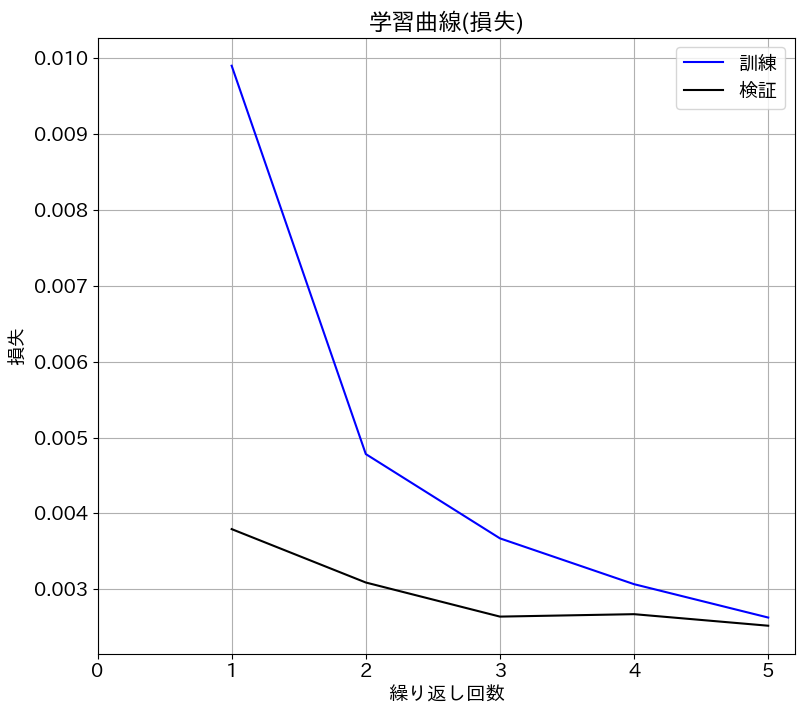

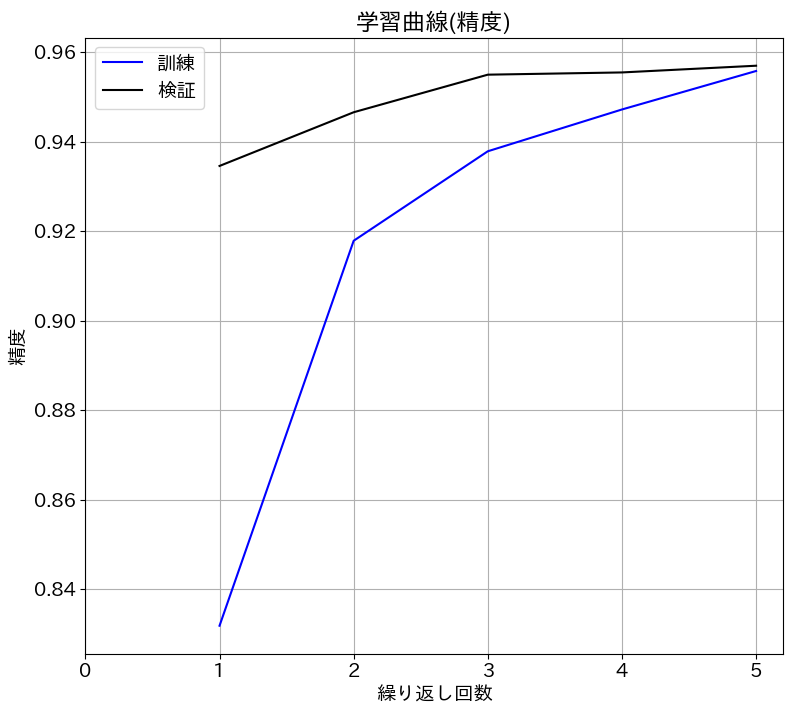

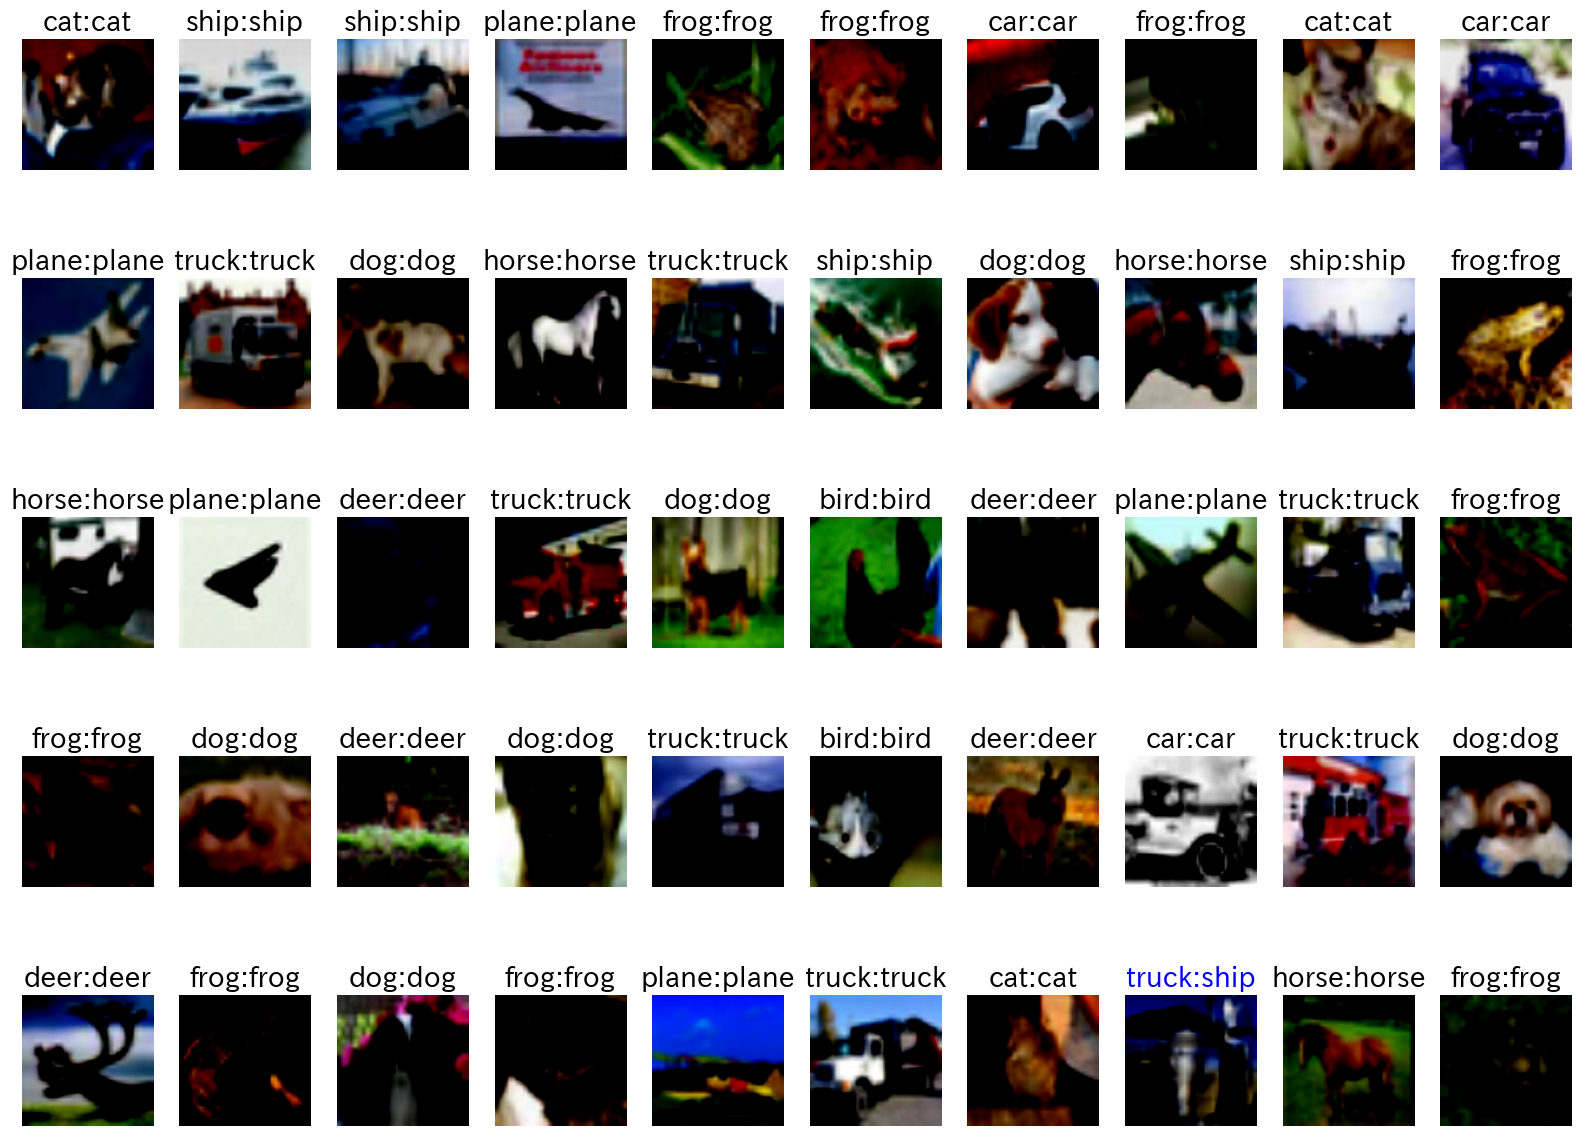

In [9]:
torch_seed()

net = models.vgg19_bn(pretrained = True)
in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, n_output)
net.features = net.features[:-1]
net.avgpool = nn.Identity()
net = net.to(device)
lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
history = np.zeros((0, 5))
num_epochs = 5

history = fit(net, optimizer, criterion, num_epochs,
          train_loader, test_loader, device, history)
evaluate_history(history)
show_images_labels(test_loader, classes, net, device)